In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [11]:
class GMM(object):
    def __init__(self, k: int, d: int, data:np.ndarray, isnormal=True):
        '''
        k: 隐变量个数
        d: 数据特征维度
        data:数据集
        isnormal:是否对数据归一化
        '''
        self.K = k
        self.D = d 
        self.isnormal=isnormal
        if isnormal:
            #数据归一化
            self.normal(data)
        else:
            self.data = data
        self.p = np.random.rand(k) # 初始化隐变量分布
        self.p = self.p / self.p.sum() # p的约束条件，保证所有p_k的和为1
        self.means = np.random.rand(k, d) # 初始化均值
        self.covs = np.empty((k, d, d)) #协方差
        for i in range(k):                  
            self.covs[i] = np.eye(d) * np.random.rand(1) * k # 初始化协方差矩阵
    def fit(self, iteration: int):
        '''
        训练模型
        iteration:迭代次数
        '''
        data = self.data #数据集
        # 存储每次迭代的均值
        means_track = np.empty((iteration, self.K, self.D)) 
        for j in range(iteration):
            # 数据的生成概率
            density = np.empty((len(data), self.K))
            for i in range(self.K):
                # 计算数据在每个分布下的概率
                norm = stats.multivariate_normal(self.means[i], self.covs[i])
                density[:,i] = norm.pdf(data)
            # 计算后验概率
            posterior = density * self.p
            posterior = posterior / posterior.sum(axis=1, keepdims=True)
            # 计算下一步的p
            p_hat = posterior.sum(axis=0)
            # 计算下一步的均值
            mean_hat = np.tensordot(posterior, data, axes=[0, 0])
            cov_hat = np.empty(self.covs.shape)
            # 计算下一步的协方差
            for i in range(self.K):
                tmp = data - self.means[i]
                cov_hat[i] = np.dot(tmp.T*posterior[:,i], tmp) / p_hat[i]
            # 更新参数
            self.covs = cov_hat
            self.means = mean_hat / p_hat.reshape(-1,1)
            self.p = p_hat / len(data)
            # 存储均值
            means_track[j] = self.means
        # 如果数据进行过归一化，则将均值还原到原始的尺度
        if self.isnormal:
            for i in range(self.D):
                means_track[:,:,i] = means_track[:,:,i]*(self.data_max[i] - self.data_min[i])+self.data_min[i]
        # 均值轨迹
        self.means_track = means_track
    def predict(self):
        """
        利用训练好的模型对数据进行聚类，类别用隐变量的下标表示，返回一个表示类别的数组
        """
        data = self.data
        # 前向概率
        density = np.empty((len(data), self.K))
        for i in range(self.K):
            # 计算前向概率
            norm = stats.multivariate_normal(self.means[i], self.covs[i])
            density[:,i] = norm.pdf(data)
        # 计算后验概率
        posterior = density * self.p
        posterior = posterior / posterior.sum(axis=1, keepdims=True)
        # 对每个样本，求后验概率最大的模型下标，作为其类别标识
        category = posterior.argmax(axis=1).flatten().tolist()
        return category
        
    def normal(self, x):
        """
        数据归一化，将数据缩放到0，1之间
        """
        # 数据每个维度的最大值和最小值
        data_max = [0]*self.D
        data_min = [0]*self.D
        for i in range(self.D):
            # 求每个维度最大值和最小值
            data_max[i] = x[:, i].max()
            data_min[i] = x[:, i].min()
            # 缩放
            x[:, i] = (x[:, i] - data_min[i]) / (data_max[i] - data_min[i])
        self.data = x
        # 存储最大值最小值便于后续数据还原
        self.data_max = data_max
        self.data_min = data_min


C:\Users\lenovo\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lenovo\anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


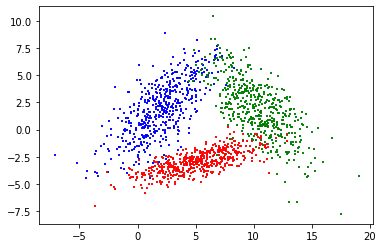

In [16]:
# 三个高斯分布的参数
cov1 = np.mat("6 8;4 2")
cov2 = np.mat("6 -8;-4 2")
cov3 = np.mat("8 2;2 1")
mu1 = np.array([2, 2])
mu2 = np.array([10, 2])
mu3 = np.array([5, -3])
# 按照设定的参数产生数据
sample = np.zeros((1500, 2))
sample[:500, :] = np.random.multivariate_normal(mean=mu1, cov=cov1, size=500)
sample[500:1000, :] = np.random.multivariate_normal(mean=mu2, cov=cov2, size=500)
sample[1000:, :] = np.random.multivariate_normal(mean=mu3, cov=cov3, size=500)
# 保存数据
np.savetxt("demo/sample.txt", sample)
# 绘图
plt.scatter(sample[:500, 0], sample[:500, 1],s=1, c="blue", marker=",")
plt.scatter(sample[500:1000, 0], sample[500:1000, 1],s=1, c="green", marker=",")
plt.scatter(sample[1000:, 0], sample[1000:, 1],s=1, c="red", marker=",")
plt.show()

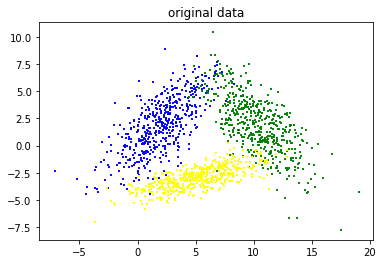

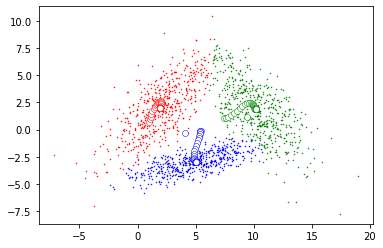

In [25]:
# 加载数据
sample = np.loadtxt("demo/sample.txt")
# 设置输出精度
np.set_printoptions(precision=3)
plt.title("original data")
# 绘制数据分布
plt.scatter(sample[:500, 0], sample[:500, 1],s=1, c="blue", marker=",")
plt.scatter(sample[500:1000, 0], sample[500:1000, 1],s=1, c="green",marker=",")
plt.scatter(sample[1000:, 0], sample[1000:, 1], s=1, c="yellow",marker=",")
plt.savefig("./demo/orignal.png",dpi=200)
plt.show()
# 打乱数据顺序
np.random.shuffle(sample)
data = np.zeros(sample.shape)
data[:] = sample[:]
# 初始化一个模型
gmm = GMM(3, 2, data, False)
# 训练，迭代300次
gmm.fit(300)
# 训练好的模型进行聚类
category = gmm.predict()
data = sample
# 将每个样本按照聚类结果放入对应类别的列表中
class1 = np.array([data[i] for i in range(len(data)) if category[i] == 0])
class2 = np.array([data[i] for i in range(len(data)) if category[i] == 1])
class3 = np.array([data[i] for i in range(len(data)) if category[i] == 2])
# 绘制聚类结果
plt.scatter(class1[:, 0], class1[:, 1],s=1,c="blue", marker=".")
plt.scatter(class2[:, 0], class2[:, 1],s=1,c="green", marker=".")
plt.scatter(class3[:, 0], class3[:, 1],s=1,c="red", marker=".")
# 绘制均值迭代轨迹
means_track = gmm.means_track
plt.scatter(means_track[:,0,0],means_track[:,0,1],c="white",marker="o",edgecolors="blue",linewidths=0.5)
plt.scatter(means_track[:,1,0],means_track[:,1,1],c="white",marker="o",edgecolors="green",linewidths=0.5)
plt.scatter(means_track[:,2,0],means_track[:,2,1],c="white",marker="o",edgecolors="red",linewidths=0.5)
plt.savefig("./demo/clustered.png",dpi=200)
plt.show()

(272, 2)


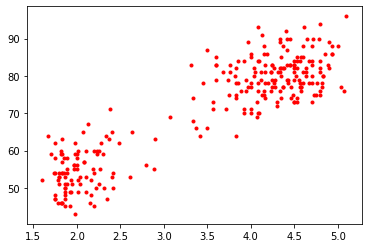

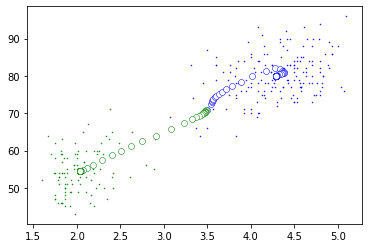

In [29]:
# 加载数据集
faithful = np.loadtxt("faithful/faithful.csv", delimiter=",", skiprows=1,usecols=(1,2))
# 绘制原始数据分布
plt.plot(faithful[:,0],faithful[:,1],"r.")
plt.savefig("./faithful/orignal.png",dpi=200)
plt.show()
data = np.zeros(faithful.shape)
data[:] = faithful[:]
# 初始化一个模型
gmm_faithful = GMM(2, 2, data)
# 模型训练，迭代100次
gmm_faithful.fit(100)
# 预测
category = gmm_faithful.predict()
# 将每个样本按照预测结果放入对应类别的列表中
data = faithful
class1 = np.array([data[i] for i in range(len(data)) if category[i] == 0])
class2 = np.array([data[i] for i in range(len(data)) if category[i] == 1])
# 绘制聚类结果图
plt.scatter(class1[:, 0], class1[:, 1],s=1,c="blue", marker=".")
plt.scatter(class2[:, 0], class2[:, 1],s=1, c="green", marker=".")
# 绘制均值轨迹
means_track = gmm_faithful.means_track
plt.scatter(means_track[:,0,0],means_track[:,0,1],c="white",marker="o",edgecolors="blue",linewidths=0.5)
plt.scatter(means_track[:,1,0],means_track[:,1,1],c="white",marker="o",edgecolors="green",linewidths=0.5)
plt.savefig("./faithful/clustered.png",dpi=200)
plt.show()

(150, 4)


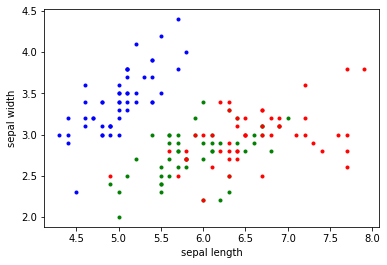

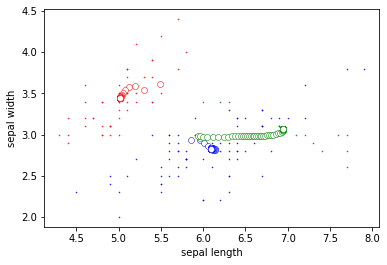

In [38]:
# 加载数据
iris  = np.loadtxt("iris/Iris.csv", delimiter=",", skiprows=1, usecols=(1, 2, 3, 4))
# 绘制原始数据分布图
plt.plot(iris[:50,0],iris[:50,1],"b.")
plt.plot(iris[50:100,0],iris[50:100,1],"g.")
plt.plot(iris[100:,0],iris[100:,1],"r.")
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.savefig("./iris/orignal.png",dpi=200)
plt.show()
# 使用前两个维度的特征
iris = iris[:,:2]
# 打乱数据顺序
np.random.shuffle(iris)
data = np.zeros(iris.shape)
data[:]=iris[:]
# 初始化模型
gmm_iris = GMM(3, 2, data)
# 模型训练
gmm_iris.fit(300)
# 预测
category = gmm_iris.predict()
# 将每个样本按照预测结果放入对应类别的列表中
data = iris
class1 = np.array([data[i] for i in range(len(data)) if category[i] == 0])
class2 = np.array([data[i] for i in range(len(data)) if category[i] == 1])
class3 = np.array([data[i] for i in range(len(data)) if category[i] == 2])
# 绘制聚类结果
plt.scatter(class1[:, 0], class1[:, 1],s=1,c="blue", marker=".")
plt.scatter(class2[:, 0], class2[:, 1],s=1,c="green", marker=".")
plt.scatter(class3[:, 0], class3[:, 1],s=1,c="red", marker=".")
# 绘制均值迭代轨迹
means_track = gmm_iris.means_track
plt.scatter(means_track[:,0,0],means_track[:,0,1],c="white",marker="o",edgecolors="blue",linewidths=0.5)
plt.scatter(means_track[:,1,0],means_track[:,1,1],c="white",marker="o",edgecolors="green",linewidths=0.5)
plt.scatter(means_track[:,2,0],means_track[:,2,1],c="white",marker="o",edgecolors="red",linewidths=0.5)
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.savefig("./iris/clustered.png",dpi=200)
plt.show()